In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import nltk
#nltk.download('all')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [3]:
!pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.1/110.1 KB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.5/287.5 KB 32.6 MB/s eta 0:00:00


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# text preprocessing
import contractions
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

# feature extraction / vectorization
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


In [6]:
df_train = pd.read_csv('/content/drive/MyDrive/Sentiment_Analysis/Data/data_train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Sentiment_Analysis/Data/data_test.csv')

X_train = df_train.Text
X_test = df_test.Text

y_train = df_train.Emotion
y_test = df_test.Emotion

class_names = ['joy', 'sadness', 'anger', 'neutral', 'fear']
data = pd.concat([df_train, df_test])

print('size of training set: %s' % (len(df_train['Text'])))
print('size of validation set: %s' % (len(df_test['Text'])))
print(data.Emotion.value_counts())

data.head()

size of training set: 7934
size of validation set: 3393
joy        2326
sadness    2317
anger      2259
neutral    2254
fear       2171
Name: Emotion, dtype: int64


,Emotion,Text
0,neutral,There are tons of other paintings that I thin...
1,sadness,"Yet the dog had grown old and less capable , a..."
2,fear,When I get into the tube or the train without ...
3,fear,This last may be a source of considerable disq...
4,anger,She disliked the intimacy he showed towards so...


In [ ]:
sentence = df_train.Text[7930]
sentence

'Irina hung up in exasperation . '

## Chuyển từng word trong sentence bằng Lemma

In [7]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import string


def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [8]:
def lemmatizer_token(review):
    review = contractions.fix(review)  
    review = review.lower()
    review = re.sub("(<.*?>)", "", review)
    review = re.sub(r'http\S+', '', review)
    review= re.sub(r"(#[\d\w\.]+)", '', review)
    review= re.sub(r"(@[\d\w\.]+)", '', review)
    review = re.sub("(\\W|\\d)", " ", review)
    review = review.strip()

    review = word_tokenize(review)
    lemmatizer = WordNetLemmatizer()
    all_stopwords = stopwords.words('english')
    all_stopwords.remove('not')
    lemma = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in review if word not in string.punctuation if not word in set(all_stopwords)]
    #lemma = ' '.join(lemma)
    #text.append(lemma)

    return lemma

In [ ]:
print(df_test['Text'][46])
print(lemmatizer_token(df_test['Text'][46]))

 I didn't like her butting in where I didn't want her . She's a chatter box . 
['not', 'like', 'butting', 'not', 'want', 'chatter', 'box']


In [ ]:
print(df_train['Text'][0])
print(lemmatizer_token(df_train['Text'][0]))

 There are tons of other paintings that I think are better . 
['ton', 'painting', 'think', 'well']


In [ ]:
words = []
for i in range(len(df_train)):
  words.append(lemmatizer_token(df_train['Text'][i]))

res = []
for i in range(len(words)):
  for j in range(len(words[i])):
    res.append(words[i][j])

In [ ]:
len(res)

59048

## Dùng TFIDF để get feature

In [ ]:
# TFIDF, unigrams and bigrams
vect = TfidfVectorizer(tokenizer=lemmatizer_token, sublinear_tf=True, norm='l2', ngram_range=(1, 2))

# fit on our complete corpus
vect.fit_transform(data.Text)

# transform testing and training datasets to vectors
X_train_vect = vect.transform(X_train)
X_test_vect = vect.transform(X_test)

In [10]:
print(X_train_vect[0])

  (0, 63029)	0.21673999437414293
  (0, 58933)	0.45381381735832493
  (0, 58932)	0.43472982533905613
  (0, 57643)	0.3885652176763226
  (0, 57484)	0.22399539141018943
  (0, 41506)	0.45381381735832493
  (0, 41499)	0.3885652176763226


In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    
    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)
    
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

## Thống kê số liệu

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


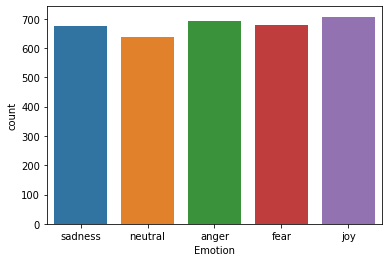

In [ ]:
sns.countplot(df_test['Emotion'])

In [ ]:
from wordcloud import WordCloud, STOPWORDS

def wordCloud(df, emotion):
  text = " ".join(cat for cat in df['Text'][df['Emotion'] == emotion])
  wordcloud = WordCloud(width = 800, height = 400, background_color ='white', min_font_size = 10).generate(text)

  plt.figure(figsize = (6, 4), facecolor = None)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout(pad = 0)

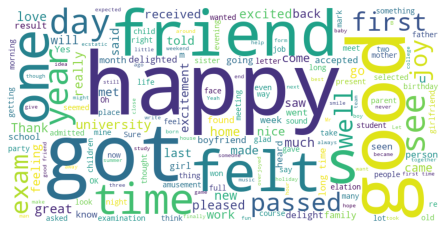

In [ ]:
wordCloud(df_train, class_names[0])

## Các pp Machine Learning

In [ ]:
from sklearn.svm import SVC

svc = SVC()
svc.fit(X_train_vect, y_train)

ysvm_pred = svc.predict(X_test_vect)

print("Accuracy: {:.2f}%".format(accuracy_score(y_test, ysvm_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, ysvm_pred, average='micro') * 100))
print("\nCOnfusion Matrix:\n", confusion_matrix(y_test, ysvm_pred))

plot_confusion_matrix(y_test, ysvm_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=0)
dt.fit(X_train_vect, y_train)

yrf_pred = dt.predict(X_test_vect)

print("Accuracy: {:.2f}%".format(accuracy_score(y_test, yrf_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, yrf_pred, average='micro') * 100))
print("\nCOnfusion Matrix:\n", confusion_matrix(y_test, yrf_pred))

plot_confusion_matrix(y_test, yrf_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 68.49%

F1 Score: 68.49

COnfusion Matrix:
 [[464  44  48  88  49]
 [ 74 465  39  59  42]
 [ 46  28 474 124  35]
 [ 40  35  58 466  39]
 [ 79  38  43  61 455]]


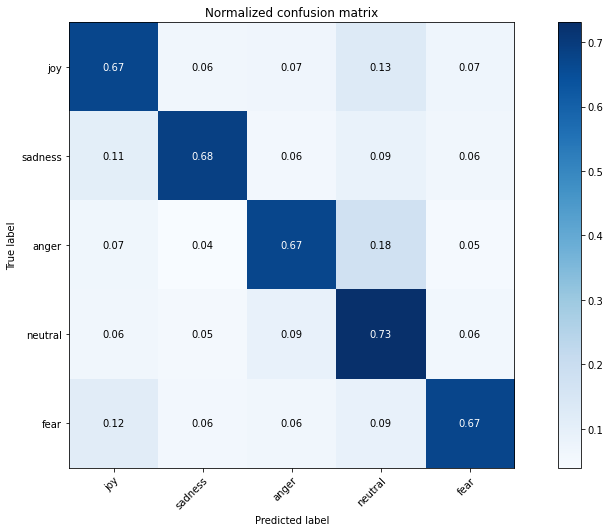

In [13]:
from sklearn.linear_model import LogisticRegression

log = LogisticRegression()
log.fit(X_train_vect, y_train)

ylog_pred = log.predict(X_test_vect)

print("Accuracy: {:.2f}%".format(accuracy_score(y_test, ylog_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, ylog_pred, average='micro') * 100))
print("\nCOnfusion Matrix:\n", confusion_matrix(y_test, ylog_pred))

plot_confusion_matrix(y_test, ylog_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

# Changing the hyperparameter

## SVM

In [ ]:
from sklearn.model_selection import GridSearchCV
import time

start = time.process_time()
param_grid = {'C': [0.1, 1, 10, 100, 1000],
			'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
			'kernel': ['linear', 'poly', 'rbf']}

grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)

# fitting the model for grid search
grid.fit(X_train_vect, y_train)
end = time.process_time()

Fitting 5 folds for each of 75 candidates, totalling 375 fits
[CV 1/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.547 total time=   6.4s
[CV 2/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.565 total time=   5.8s
[CV 3/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.558 total time=   5.8s
[CV 4/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.581 total time=   8.0s
[CV 5/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.575 total time=   5.8s
[CV 1/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.235 total time=   6.0s
[CV 2/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.250 total time=   6.1s
[CV 3/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.241 total time=   6.0s
[CV 4/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.251 total time=   6.0s
[CV 5/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.254 total time=   6.0s
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.338 total time=   7.2s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf

In [ ]:
# print best parameter after tuning
print(grid.best_params_)

# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'C': 10, 'gamma': 1, 'kernel': 'rbf'}
SVC(C=10, gamma=1)


In [ ]:
from sklearn.metrics import classification_report
grid_predictions = grid.predict(X_test_vect)
print(classification_report(y_test, grid_predictions))

              precision    recall  f1-score   support

       anger       0.65      0.72      0.69       693
        fear       0.74      0.71      0.73       679
         joy       0.71      0.70      0.70       707
     neutral       0.69      0.70      0.69       638
     sadness       0.74      0.68      0.71       676

    accuracy                           0.70      3393
   macro avg       0.71      0.70      0.70      3393
weighted avg       0.71      0.70      0.70      3393



Accuracy: 70.38%

F1 Score: 70.38

COnfusion Matrix:
 [[501  50  42  54  46]
 [ 70 485  50  27  47]
 [ 54  41 495  81  36]
 [ 53  33  73 447  32]
 [ 87  48  40  41 460]]


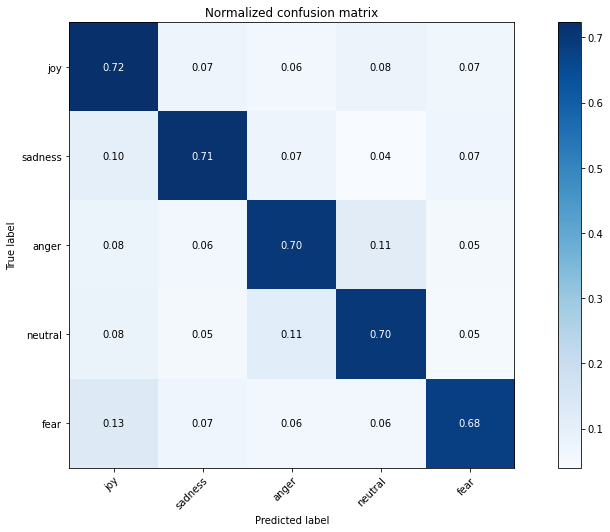

In [ ]:
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, grid_predictions) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, grid_predictions, average='micro') * 100))
print("\nCOnfusion Matrix:\n", confusion_matrix(y_test, grid_predictions))
plot_confusion_matrix(y_test, grid_predictions, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

## Logistic

In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

param_grid = {
              'C':[0.01,0.1,1,10,100],
			'solver': ['newton-cg','lbfgs','liblinear'],
      'multi_class': ['auto', 'ovr', 'multinomial'],
      'max_iter': [100,200,300]}

grid = GridSearchCV(LogisticRegression(), param_grid, verbose = 3)

# fitting the model for grid search
grid.fit(X_train_vect, y_train)

Fitting 5 folds for each of 135 candidates, totalling 675 fits
[CV 1/5] END C=0.01, max_iter=100, multi_class=auto, solver=newton-cg;, score=0.374 total time=   1.4s
[CV 2/5] END C=0.01, max_iter=100, multi_class=auto, solver=newton-cg;, score=0.396 total time=   0.9s
[CV 3/5] END C=0.01, max_iter=100, multi_class=auto, solver=newton-cg;, score=0.389 total time=   0.5s
[CV 4/5] END C=0.01, max_iter=100, multi_class=auto, solver=newton-cg;, score=0.388 total time=   0.5s
[CV 5/5] END C=0.01, max_iter=100, multi_class=auto, solver=newton-cg;, score=0.371 total time=   0.6s
[CV 1/5] END C=0.01, max_iter=100, multi_class=auto, solver=lbfgs;, score=0.374 total time=   1.6s
[CV 2/5] END C=0.01, max_iter=100, multi_class=auto, solver=lbfgs;, score=0.396 total time=   1.4s
[CV 3/5] END C=0.01, max_iter=100, multi_class=auto, solver=lbfgs;, score=0.389 total time=   1.5s
[CV 4/5] END C=0.01, max_iter=100, multi_class=auto, solver=lbfgs;, score=0.388 total time=   1.2s
[CV 5/5] END C=0.01, max_i

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END C=1, max_iter=100, multi_class=auto, solver=lbfgs;, score=0.673 total time=   8.3s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END C=1, max_iter=100, multi_class=auto, solver=lbfgs;, score=0.662 total time=   7.9s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END C=1, max_iter=100, multi_class=auto, solver=lbfgs;, score=0.686 total time=   7.9s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END C=1, max_iter=100, multi_class=auto, solver=lbfgs;, score=0.672 total time=   8.4s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END C=1, max_iter=100, multi_class=auto, solver=lbfgs;, score=0.659 total time=   8.4s
[CV 1/5] END C=1, max_iter=100, multi_class=auto, solver=liblinear;, score=0.665 total time=   0.3s
[CV 2/5] END C=1, max_iter=100, multi_class=auto, solver=liblinear;, score=0.653 total time=   0.3s
[CV 3/5] END C=1, max_iter=100, multi_class=auto, solver=liblinear;, score=0.679 total time=   0.3s
[CV 4/5] END C=1, max_iter=100, multi_class=auto, solver=liblinear;, score=0.664 total time=   0.2s
[CV 5/5] END C=1, max_iter=100, multi_class=auto, solver=liblinear;, score=0.659 total time=   0.3s
[CV 1/5] END C=1, max_iter=100, multi_class=ovr, solver=newton-cg;, score=0.665 total time=   1.1s
[CV 2/5] END C=1, max_iter=100, multi_class=ovr, solver=newton-cg;, score=0.653 total time=   1.0s
[CV 3/5] END C=1, max_iter=100, multi_class=ovr, solver=newton-cg;, score=0.679 total time=   1.1s
[CV 4/5] END C=1, max_iter=100, multi_class=ovr, solver=newton-cg;, score=0.664 total time=   1.0s
[CV 5/5]

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END C=1, max_iter=100, multi_class=multinomial, solver=lbfgs;, score=0.673 total time=   8.5s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END C=1, max_iter=100, multi_class=multinomial, solver=lbfgs;, score=0.662 total time=   8.4s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END C=1, max_iter=100, multi_class=multinomial, solver=lbfgs;, score=0.686 total time=   7.7s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END C=1, max_iter=100, multi_class=multinomial, solver=lbfgs;, score=0.672 total time=   7.8s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END C=1, max_iter=100, multi_class=multinomial, solver=lbfgs;, score=0.659 total time=   9.4s
[CV 1/5] END C=1, max_iter=100, multi_class=multinomial, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5] END C=1, max_iter=100, multi_class=multinomial, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5] END C=1, max_iter=100, multi_class=multinomial, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5] END C=1, max_iter=100, multi_class=multinomial, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5] END C=1, max_iter=100, multi_class=multinomial, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5] END C=1, max_iter=200, multi_class=auto, solver=newton-cg;, score=0.673 total time=   1.6s
[CV 2/5] END C=1, max_iter=200, multi_class=auto, solver=newton-cg;, score=0.662 total time=   1.4s
[CV 3/5] END C=1, max_iter=200, multi_class=auto, solver=newton-cg;, score=0.686 total time=   1.3s
[CV 4/5] END C=1, max_iter=200, multi_class=auto, solver=newton-cg;, sco

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END C=10, max_iter=100, multi_class=auto, solver=lbfgs;, score=0.669 total time=   8.8s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END C=10, max_iter=100, multi_class=auto, solver=lbfgs;, score=0.650 total time=   8.0s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END C=10, max_iter=100, multi_class=auto, solver=lbfgs;, score=0.679 total time=   7.6s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END C=10, max_iter=100, multi_class=auto, solver=lbfgs;, score=0.674 total time=   8.3s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END C=10, max_iter=100, multi_class=auto, solver=lbfgs;, score=0.650 total time=   8.2s
[CV 1/5] END C=10, max_iter=100, multi_class=auto, solver=liblinear;, score=0.674 total time=   0.4s
[CV 2/5] END C=10, max_iter=100, multi_class=auto, solver=liblinear;, score=0.662 total time=   0.4s
[CV 3/5] END C=10, max_iter=100, multi_class=auto, solver=liblinear;, score=0.689 total time=   0.4s
[CV 4/5] END C=10, max_iter=100, multi_class=auto, solver=liblinear;, score=0.679 total time=   0.5s
[CV 5/5] END C=10, max_iter=100, multi_class=auto, solver=liblinear;, score=0.670 total time=   0.4s
[CV 1/5] END C=10, max_iter=100, multi_class=ovr, solver=newton-cg;, score=0.674 total time=   1.6s
[CV 2/5] END C=10, max_iter=100, multi_class=ovr, solver=newton-cg;, score=0.662 total time=   1.5s
[CV 3/5] END C=10, max_iter=100, multi_class=ovr, solver=newton-cg;, score=0.689 total time=   1.6s
[CV 4/5] END C=10, max_iter=100, multi_class=ovr, solver=newton-cg;, score=0.679 total time=   1.5

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

[CV 1/5] END C=10, max_iter=100, multi_class=ovr, solver=lbfgs;, score=0.674 total time=   7.8s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

[CV 2/5] END C=10, max_iter=100, multi_class=ovr, solver=lbfgs;, score=0.662 total time=   8.0s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

[CV 3/5] END C=10, max_iter=100, multi_class=ovr, solver=lbfgs;, score=0.689 total time=   8.0s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

[CV 4/5] END C=10, max_iter=100, multi_class=ovr, solver=lbfgs;, score=0.679 total time=   7.9s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

[CV 5/5] END C=10, max_iter=100, multi_class=ovr, solver=lbfgs;, score=0.670 total time=   7.7s
[CV 1/5] END C=10, max_iter=100, multi_class=ovr, solver=liblinear;, score=0.674 total time=   0.5s
[CV 2/5] END C=10, max_iter=100, multi_class=ovr, solver=liblinear;, score=0.662 total time=   0.4s
[CV 3/5] END C=10, max_iter=100, multi_class=ovr, solver=liblinear;, score=0.689 total time=   0.4s
[CV 4/5] END C=10, max_iter=100, multi_class=ovr, solver=liblinear;, score=0.679 total time=   0.4s
[CV 5/5] END C=10, max_iter=100, multi_class=ovr, solver=liblinear;, score=0.670 total time=   0.4s
[CV 1/5] END C=10, max_iter=100, multi_class=multinomial, solver=newton-cg;, score=0.669 total time=   2.6s
[CV 2/5] END C=10, max_iter=100, multi_class=multinomial, solver=newton-cg;, score=0.652 total time=   2.3s
[CV 3/5] END C=10, max_iter=100, multi_class=multinomial, solver=newton-cg;, score=0.679 total time=   2.5s
[CV 4/5] END C=10, max_iter=100, multi_class=multinomial, solver=newton-cg;, sco

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END C=10, max_iter=100, multi_class=multinomial, solver=lbfgs;, score=0.669 total time=   7.6s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END C=10, max_iter=100, multi_class=multinomial, solver=lbfgs;, score=0.650 total time=   7.8s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END C=10, max_iter=100, multi_class=multinomial, solver=lbfgs;, score=0.679 total time=   9.7s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END C=10, max_iter=100, multi_class=multinomial, solver=lbfgs;, score=0.674 total time=   9.0s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END C=10, max_iter=100, multi_class=multinomial, solver=lbfgs;, score=0.650 total time=   8.5s
[CV 1/5] END C=10, max_iter=100, multi_class=multinomial, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5] END C=10, max_iter=100, multi_class=multinomial, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5] END C=10, max_iter=100, multi_class=multinomial, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5] END C=10, max_iter=100, multi_class=multinomial, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5] END C=10, max_iter=100, multi_class=multinomial, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5] END C=10, max_iter=200, multi_class=auto, solver=newton-cg;, score=0.669 total time=   2.2s
[CV 2/5] END C=10, max_iter=200, multi_class=auto, solver=newton-cg;, score=0.652 total time=   2.0s
[CV 3/5] END C=10, max_iter=200, multi_class=auto, solver=newton-cg;, score=0.679 total time=   2.3s
[CV 4/5] END C=10, max_iter=200, multi_class=auto, solver=newto

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END C=10, max_iter=200, multi_class=auto, solver=lbfgs;, score=0.669 total time=  16.0s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END C=10, max_iter=200, multi_class=auto, solver=lbfgs;, score=0.653 total time=  15.8s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END C=10, max_iter=200, multi_class=auto, solver=lbfgs;, score=0.679 total time=  15.2s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END C=10, max_iter=200, multi_class=auto, solver=lbfgs;, score=0.671 total time=  16.9s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END C=10, max_iter=200, multi_class=auto, solver=lbfgs;, score=0.653 total time=  14.6s
[CV 1/5] END C=10, max_iter=200, multi_class=auto, solver=liblinear;, score=0.674 total time=   0.5s
[CV 2/5] END C=10, max_iter=200, multi_class=auto, solver=liblinear;, score=0.662 total time=   0.4s
[CV 3/5] END C=10, max_iter=200, multi_class=auto, solver=liblinear;, score=0.689 total time=   0.4s
[CV 4/5] END C=10, max_iter=200, multi_class=auto, solver=liblinear;, score=0.679 total time=   0.4s
[CV 5/5] END C=10, max_iter=200, multi_class=auto, solver=liblinear;, score=0.670 total time=   0.4s
[CV 1/5] END C=10, max_iter=200, multi_class=ovr, solver=newton-cg;, score=0.674 total time=   1.5s
[CV 2/5] END C=10, max_iter=200, multi_class=ovr, solver=newton-cg;, score=0.662 total time=   1.4s
[CV 3/5] END C=10, max_iter=200, multi_class=ovr, solver=newton-cg;, score=0.689 total time=   1.5s
[CV 4/5] END C=10, max_iter=200, multi_class=ovr, solver=newton-cg;, score=0.679 total time=   1.5

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END C=10, max_iter=200, multi_class=multinomial, solver=lbfgs;, score=0.669 total time=  15.1s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END C=10, max_iter=200, multi_class=multinomial, solver=lbfgs;, score=0.653 total time=  16.4s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END C=10, max_iter=200, multi_class=multinomial, solver=lbfgs;, score=0.679 total time=  15.2s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END C=10, max_iter=200, multi_class=multinomial, solver=lbfgs;, score=0.671 total time=  15.6s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END C=10, max_iter=200, multi_class=multinomial, solver=lbfgs;, score=0.653 total time=  14.8s
[CV 1/5] END C=10, max_iter=200, multi_class=multinomial, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5] END C=10, max_iter=200, multi_class=multinomial, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5] END C=10, max_iter=200, multi_class=multinomial, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5] END C=10, max_iter=200, multi_class=multinomial, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5] END C=10, max_iter=200, multi_class=multinomial, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5] END C=10, max_iter=300, multi_class=auto, solver=newton-cg;, score=0.669 total time=   2.1s
[CV 2/5] END C=10, max_iter=300, multi_class=auto, solver=newton-cg;, score=0.652 total time=   1.9s
[CV 3/5] END C=10, max_iter=300, multi_class=auto, solver=newton-cg;, score=0.679 total time=   2.2s
[CV 4/5] END C=10, max_iter=300, multi_class=auto, solver=newto

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END C=100, max_iter=100, multi_class=auto, solver=lbfgs;, score=0.660 total time=   9.5s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END C=100, max_iter=100, multi_class=auto, solver=lbfgs;, score=0.633 total time=   8.1s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END C=100, max_iter=100, multi_class=auto, solver=lbfgs;, score=0.653 total time=   8.5s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END C=100, max_iter=100, multi_class=auto, solver=lbfgs;, score=0.660 total time=   8.9s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END C=100, max_iter=100, multi_class=auto, solver=lbfgs;, score=0.642 total time=   8.8s
[CV 1/5] END C=100, max_iter=100, multi_class=auto, solver=liblinear;, score=0.660 total time=   0.8s
[CV 2/5] END C=100, max_iter=100, multi_class=auto, solver=liblinear;, score=0.641 total time=   0.6s
[CV 3/5] END C=100, max_iter=100, multi_class=auto, solver=liblinear;, score=0.665 total time=   0.7s
[CV 4/5] END C=100, max_iter=100, multi_class=auto, solver=liblinear;, score=0.664 total time=   0.6s
[CV 5/5] END C=100, max_iter=100, multi_class=auto, solver=liblinear;, score=0.653 total time=   0.7s
[CV 1/5] END C=100, max_iter=100, multi_class=ovr, solver=newton-cg;, score=0.660 total time=   2.5s
[CV 2/5] END C=100, max_iter=100, multi_class=ovr, solver=newton-cg;, score=0.641 total time=   2.3s
[CV 3/5] END C=100, max_iter=100, multi_class=ovr, solver=newton-cg;, score=0.664 total time=   2.2s
[CV 4/5] END C=100, max_iter=100, multi_class=ovr, solver=newton-cg;, score=0.664 total t

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

[CV 1/5] END C=100, max_iter=100, multi_class=ovr, solver=lbfgs;, score=0.664 total time=   7.9s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

[CV 2/5] END C=100, max_iter=100, multi_class=ovr, solver=lbfgs;, score=0.641 total time=   7.8s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

[CV 3/5] END C=100, max_iter=100, multi_class=ovr, solver=lbfgs;, score=0.666 total time=   7.5s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

[CV 4/5] END C=100, max_iter=100, multi_class=ovr, solver=lbfgs;, score=0.665 total time=   7.9s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

[CV 5/5] END C=100, max_iter=100, multi_class=ovr, solver=lbfgs;, score=0.656 total time=   7.6s
[CV 1/5] END C=100, max_iter=100, multi_class=ovr, solver=liblinear;, score=0.660 total time=   0.8s
[CV 2/5] END C=100, max_iter=100, multi_class=ovr, solver=liblinear;, score=0.641 total time=   0.6s
[CV 3/5] END C=100, max_iter=100, multi_class=ovr, solver=liblinear;, score=0.665 total time=   0.8s
[CV 4/5] END C=100, max_iter=100, multi_class=ovr, solver=liblinear;, score=0.664 total time=   0.6s
[CV 5/5] END C=100, max_iter=100, multi_class=ovr, solver=liblinear;, score=0.653 total time=   0.6s
[CV 1/5] END C=100, max_iter=100, multi_class=multinomial, solver=newton-cg;, score=0.660 total time=   4.8s
[CV 2/5] END C=100, max_iter=100, multi_class=multinomial, solver=newton-cg;, score=0.630 total time=   4.4s
[CV 3/5] END C=100, max_iter=100, multi_class=multinomial, solver=newton-cg;, score=0.664 total time=   3.9s
[CV 4/5] END C=100, max_iter=100, multi_class=multinomial, solver=newto

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END C=100, max_iter=100, multi_class=multinomial, solver=lbfgs;, score=0.660 total time=   8.4s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END C=100, max_iter=100, multi_class=multinomial, solver=lbfgs;, score=0.633 total time=   8.4s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END C=100, max_iter=100, multi_class=multinomial, solver=lbfgs;, score=0.653 total time=   9.5s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END C=100, max_iter=100, multi_class=multinomial, solver=lbfgs;, score=0.660 total time=   7.8s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END C=100, max_iter=100, multi_class=multinomial, solver=lbfgs;, score=0.642 total time=   8.4s
[CV 1/5] END C=100, max_iter=100, multi_class=multinomial, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5] END C=100, max_iter=100, multi_class=multinomial, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5] END C=100, max_iter=100, multi_class=multinomial, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5] END C=100, max_iter=100, multi_class=multinomial, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5] END C=100, max_iter=100, multi_class=multinomial, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5] END C=100, max_iter=200, multi_class=auto, solver=newton-cg;, score=0.660 total time=   4.1s
[CV 2/5] END C=100, max_iter=200, multi_class=auto, solver=newton-cg;, score=0.630 total time=   3.9s
[CV 3/5] END C=100, max_iter=200, multi_class=auto, solver=newton-cg;, score=0.664 total time=   3.4s
[CV 4/5] END C=100, max_iter=200, multi_class=auto, so

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END C=100, max_iter=200, multi_class=auto, solver=lbfgs;, score=0.661 total time=  15.4s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END C=100, max_iter=200, multi_class=auto, solver=lbfgs;, score=0.633 total time=  15.8s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END C=100, max_iter=200, multi_class=auto, solver=lbfgs;, score=0.662 total time=  15.8s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END C=100, max_iter=200, multi_class=auto, solver=lbfgs;, score=0.657 total time=  15.3s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END C=100, max_iter=200, multi_class=auto, solver=lbfgs;, score=0.644 total time=  14.7s
[CV 1/5] END C=100, max_iter=200, multi_class=auto, solver=liblinear;, score=0.660 total time=   0.8s
[CV 2/5] END C=100, max_iter=200, multi_class=auto, solver=liblinear;, score=0.641 total time=   0.6s
[CV 3/5] END C=100, max_iter=200, multi_class=auto, solver=liblinear;, score=0.665 total time=   0.7s
[CV 4/5] END C=100, max_iter=200, multi_class=auto, solver=liblinear;, score=0.664 total time=   0.6s
[CV 5/5] END C=100, max_iter=200, multi_class=auto, solver=liblinear;, score=0.653 total time=   0.6s
[CV 1/5] END C=100, max_iter=200, multi_class=ovr, solver=newton-cg;, score=0.660 total time=   2.4s
[CV 2/5] END C=100, max_iter=200, multi_class=ovr, solver=newton-cg;, score=0.641 total time=   2.3s
[CV 3/5] END C=100, max_iter=200, multi_class=ovr, solver=newton-cg;, score=0.664 total time=   2.2s
[CV 4/5] END C=100, max_iter=200, multi_class=ovr, solver=newton-cg;, score=0.664 total t

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

[CV 1/5] END C=100, max_iter=200, multi_class=ovr, solver=lbfgs;, score=0.661 total time=  15.1s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

[CV 2/5] END C=100, max_iter=200, multi_class=ovr, solver=lbfgs;, score=0.641 total time=  14.3s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

[CV 3/5] END C=100, max_iter=200, multi_class=ovr, solver=lbfgs;, score=0.665 total time=  13.2s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

[CV 4/5] END C=100, max_iter=200, multi_class=ovr, solver=lbfgs;, score=0.664 total time=  13.4s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

[CV 5/5] END C=100, max_iter=200, multi_class=ovr, solver=lbfgs;, score=0.653 total time=  13.5s
[CV 1/5] END C=100, max_iter=200, multi_class=ovr, solver=liblinear;, score=0.660 total time=   0.8s
[CV 2/5] END C=100, max_iter=200, multi_class=ovr, solver=liblinear;, score=0.641 total time=   0.6s
[CV 3/5] END C=100, max_iter=200, multi_class=ovr, solver=liblinear;, score=0.665 total time=   0.7s
[CV 4/5] END C=100, max_iter=200, multi_class=ovr, solver=liblinear;, score=0.664 total time=   0.6s
[CV 5/5] END C=100, max_iter=200, multi_class=ovr, solver=liblinear;, score=0.653 total time=   0.6s
[CV 1/5] END C=100, max_iter=200, multi_class=multinomial, solver=newton-cg;, score=0.660 total time=   4.8s
[CV 2/5] END C=100, max_iter=200, multi_class=multinomial, solver=newton-cg;, score=0.630 total time=   4.5s
[CV 3/5] END C=100, max_iter=200, multi_class=multinomial, solver=newton-cg;, score=0.664 total time=   3.9s
[CV 4/5] END C=100, max_iter=200, multi_class=multinomial, solver=newto

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END C=100, max_iter=200, multi_class=multinomial, solver=lbfgs;, score=0.661 total time=  15.6s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END C=100, max_iter=200, multi_class=multinomial, solver=lbfgs;, score=0.633 total time=  15.4s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END C=100, max_iter=200, multi_class=multinomial, solver=lbfgs;, score=0.662 total time=  15.1s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END C=100, max_iter=200, multi_class=multinomial, solver=lbfgs;, score=0.657 total time=  16.8s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END C=100, max_iter=200, multi_class=multinomial, solver=lbfgs;, score=0.644 total time=  17.1s
[CV 1/5] END C=100, max_iter=200, multi_class=multinomial, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5] END C=100, max_iter=200, multi_class=multinomial, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5] END C=100, max_iter=200, multi_class=multinomial, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5] END C=100, max_iter=200, multi_class=multinomial, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5] END C=100, max_iter=200, multi_class=multinomial, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5] END C=100, max_iter=300, multi_class=auto, solver=newton-cg;, score=0.660 total time=   4.7s
[CV 2/5] END C=100, max_iter=300, multi_class=auto, solver=newton-cg;, score=0.630 total time=   4.4s
[CV 3/5] END C=100, max_iter=300, multi_class=auto, solver=newton-cg;, score=0.664 total time=   3.9s
[CV 4/5] END C=100, max_iter=300, multi_class=auto, so

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END C=100, max_iter=300, multi_class=auto, solver=lbfgs;, score=0.660 total time=  24.8s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END C=100, max_iter=300, multi_class=auto, solver=lbfgs;, score=0.631 total time=  21.9s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END C=100, max_iter=300, multi_class=auto, solver=lbfgs;, score=0.664 total time=  22.1s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END C=100, max_iter=300, multi_class=auto, solver=lbfgs;, score=0.655 total time=  22.9s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END C=100, max_iter=300, multi_class=auto, solver=lbfgs;, score=0.643 total time=  24.7s
[CV 1/5] END C=100, max_iter=300, multi_class=auto, solver=liblinear;, score=0.660 total time=   0.8s
[CV 2/5] END C=100, max_iter=300, multi_class=auto, solver=liblinear;, score=0.641 total time=   0.6s
[CV 3/5] END C=100, max_iter=300, multi_class=auto, solver=liblinear;, score=0.665 total time=   0.7s
[CV 4/5] END C=100, max_iter=300, multi_class=auto, solver=liblinear;, score=0.664 total time=   0.6s
[CV 5/5] END C=100, max_iter=300, multi_class=auto, solver=liblinear;, score=0.653 total time=   0.7s
[CV 1/5] END C=100, max_iter=300, multi_class=ovr, solver=newton-cg;, score=0.660 total time=   2.4s
[CV 2/5] END C=100, max_iter=300, multi_class=ovr, solver=newton-cg;, score=0.641 total time=   2.4s
[CV 3/5] END C=100, max_iter=300, multi_class=ovr, solver=newton-cg;, score=0.664 total time=   2.3s
[CV 4/5] END C=100, max_iter=300, multi_class=ovr, solver=newton-cg;, score=0.664 total t

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END C=100, max_iter=300, multi_class=multinomial, solver=lbfgs;, score=0.660 total time=  26.2s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END C=100, max_iter=300, multi_class=multinomial, solver=lbfgs;, score=0.631 total time=  24.5s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END C=100, max_iter=300, multi_class=multinomial, solver=lbfgs;, score=0.664 total time=  24.4s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END C=100, max_iter=300, multi_class=multinomial, solver=lbfgs;, score=0.655 total time=  25.1s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
75 fits failed out of a total of 675.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Tracebac

[CV 5/5] END C=100, max_iter=300, multi_class=multinomial, solver=lbfgs;, score=0.643 total time=  22.1s
[CV 1/5] END C=100, max_iter=300, multi_class=multinomial, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5] END C=100, max_iter=300, multi_class=multinomial, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5] END C=100, max_iter=300, multi_class=multinomial, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5] END C=100, max_iter=300, multi_class=multinomial, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5] END C=100, max_iter=300, multi_class=multinomial, solver=liblinear;, score=nan total time=   0.0s


GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'max_iter': [100, 200, 300],
                         'multi_class': ['auto', 'ovr', 'multinomial'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             verbose=3)

In [29]:
print(grid.best_params_)
print(grid.best_estimator_)

{'C': 10, 'max_iter': 100, 'multi_class': 'auto', 'solver': 'liblinear'}
LogisticRegression(C=10, solver='liblinear')


Accuracy: 68.55%

F1 Score: 68.55

COnfusion Matrix:
 [[440  43  37 120  53]
 [ 51 460  35  88  45]
 [ 38  28 462 146  33]
 [ 27  26  48 503  34]
 [ 66  34  38  77 461]]


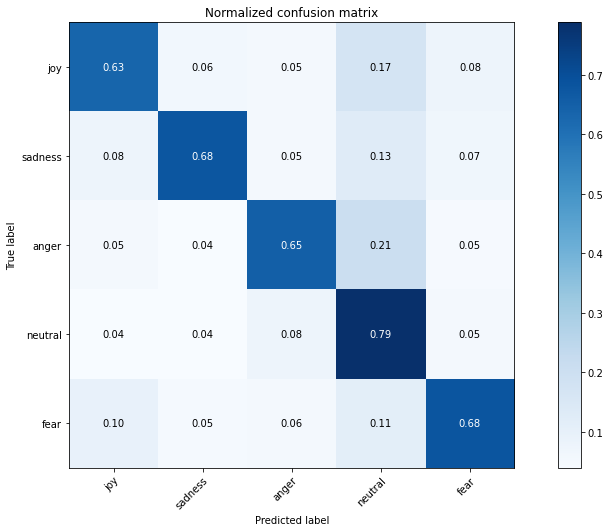

In [30]:
grid_predictions = grid.predict(X_test_vect)
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, grid_predictions) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, grid_predictions, average='micro') * 100))
print("\nCOnfusion Matrix:\n", confusion_matrix(y_test, grid_predictions))
plot_confusion_matrix(y_test, grid_predictions, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

## Decision Tree

In [ ]:
from matplotlib import Parameter
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text

model = DecisionTreeClassifier(random_state=0, max_depth=100)
model.fit(X_train_vect, y_train)

Parameter = 

yrf_pred = model.predict(X_test_vect)

print("Accuracy: {:.2f}%".format(accuracy_score(y_test, yrf_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, yrf_pred, average='micro') * 100))
print("\nCOnfusion Matrix:\n", confusion_matrix(y_test, yrf_pred))

plot_confusion_matrix(y_test, yrf_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

SyntaxError: ignored

##Save model and Demo

In [ ]:
from sklearn.pipeline import Pipeline
import pickle

In [ ]:
#Create pipeline with tf-idf vectorizer and Logistic model
LinearSVC_model = Pipeline([
    ('tfidf', vect),
    ('clf', svc),
])

# save the model
filename = '/content/SVC.sav'
pickle.dump(LinearSVC_model, open(filename, 'wb'))


model = pickle.load(open(filename, 'rb'))
message = 'I saw a ghost last day' 
print(model.predict([message]))